In [1]:
# ===============
# To 1) choose a method of combining/bias correcting the chosen analogues, and
#    2) calculate/plot the skill against other baselines
# Note: For the original paper, the ANNUAL version was used (not the trend version)
# ===============
import getpass
usr = getpass.getuser()

figure_dir = '/home/users/{}/python/output_figures/'.format(usr)
data_dir = '/home/users/{}/data'.format(usr)
processed_output_dir = '/home/users/{}/data/'.format(usr)
scripts_dir = '/home/users/{}/python/scripts3/'.format(usr)

print(data_dir)

# TODO: NOTE (Nov 2020)
# I don't think I am consistent with "chosen_num_mem" here. i.e. Sometimes I count from the end, backwards. Other
# times I seem to count forwards. If chosen_num_mem is 20 or greater then I am using all of the members in the file
# so it's okay, but I should be more careful...

/home/users/lfbor/data


In [2]:
# ===============
# Various choices
# ===============
analogue_var = 'SST'
forecast_var = 'SST'

picontrols_only = False
skip_local_hist = False
strong_forcing_only = False

# just_plot_annual = False
do_slow_plots = False

stop_analogues_early_like_dcpp = False  # This is pointless as the last actual forecast of LT2-10 is from 2009 anyway

# ===============
# These correspond to the output (file name) from STEP3a
# ===============
# target_regions  = ['north_atlantic', 'subpolar_gyre']
# target_domain_strings = ['+65+00+00-90', '+65+10+45-60', '+50+00+40-70', '+30+20+00-85', '+30+20+05-60']
# windows = [1, 2, 3, 5, 7, 10, 15, 25, 35, 45]
# smoothings = [1, 11, 21]
chosen_target_region = 'subpolar_gyre'  # The region we are computing the skill for
chosen_target_domain = '+65+00+00-90'   # The region we used when choosing the "best" analogues
chosen_window = 35                      # The window over which we chose the best analogues (trends over this period)
chosen_smoothing = 5                    # The length of any prior smoothing applied
chosen_num_mem = 100                    # The number of analogue memebrs to allow into the ensemble each time
chosen_norm_window = 35                 # IMPORTANT! This is the window over which we (might) scale the variance and is not necessarily the same as the analogue creation window defined above
clim_start, clim_end = 1960, 1990       # The climatology period we used (e.g. all models/experiments (and obs) had this (historical) period time-mean removed)
rmse_method = True                      # Whether our skill metric was RMSE or correlation

# ===============
# Which of the predefined methods of bias correction (or "re-centering" to use)
# ===============
old_recentre_method = False
new_recentre_method = False
new_recentre_method2 = False
new_recentre_method2b = False
simple_recentre_method = False
simpleScaled_recentre_method = False
clever_scaling_method = False  # Time series look nice
clever_scaling_methodb = False
clever_scaling_methodc = True  #  (New TS Map method does the same as this (assuming divide_by_sd=FALSE in maps))
# clever_scaling_methodd = True  #  As C but shifting by mean over previous chosen_window rather than t=0
# clever_scaling_methode = False  #  As D but also normalising MMM over that window rather than full analogue window
map_method = False  # (Old map method)
map_method_nosd = False

do_ltbc = True

hadisst_spg_2020 = 9.441540503229705 # Estimated from ReadHadISST_ASCII.ipynb. TODO: Update hadisst data

In [3]:
import numpy as np
import xarray as xr
import glob
import pickle
import os
import sys
import matplotlib.pyplot as plt
import time
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.stats import gaussian_kde

sys.path.insert(0, '/home/users/lfbor/python/scripts3/python_modules')
from analogue import *

%matplotlib inline

if (clim_start != 1960) or (clim_end != 1990):
    clim_string = '_Clim{:d}{:d}'.format(clim_start, clim_end)
    processed_output_dir += '_{:d}-{:d}'.format(clim_start, clim_end)
else:
    clim_string = ''
    
hadisst_save_file = '{:s}/HadISST_time_series_regions.pkl'.format(data_dir)
baseline_save_file = '{:s}/Analogues_{:s}_BaselineSkillMeasures_{:s}.pkl'.format(data_dir, forecast_var, chosen_target_region)

print(baseline_save_file)
    
en4_save_file = '{:s}/EN4_0-500m_time_series_regions.pkl'.format(data_dir)
hadcrut4_save_file = '{:s}/HadCRUT4_time_series_regions.pkl'.format(data_dir)

max_mems_to_take = 20
if chosen_num_mem > max_mems_to_take:
    max_mems_to_take = chosen_num_mem
nlead = 11
lead_times = np.arange(nlead)
norm_windows = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 18, 20, 25, 30, 35, 45])
ichosen_norm_window = np.argwhere(norm_windows == chosen_norm_window)
if len(ichosen_norm_window) == 0: raise ValueError('Must choose from the allowed norm_windows')
ichosen_norm_window = ichosen_norm_window[0][0]
# def read_target_domain(in_string):
#     out_list = []
#     for ii in range(4):
#         out_list.append(np.int(in_string[ii*3:(ii+1)*3]))
#     return out_list

# Read the historical data for validation
if forecast_var == 'SST':
    forecast_save_file = hadisst_save_file
elif forecast_var == 'DepthAverageT':
    forecast_save_file = en4_save_file
elif forecast_var == 'SAT':
    forecast_save_file = hadcrut4_save_file
else:
    raise ValueError('Unknown variable')
with open(forecast_save_file, 'rb') as handle:
    print("Loading save file: {:s}".format(forecast_save_file))
    _, forecast_obs, _, year_forecast_obs = pickle.load(handle, encoding='latin')
    forecast_obs = forecast_obs[chosen_target_region]
    nyrs = len(year_forecast_obs)
print('nyrs', nyrs)

if old_recentre_method:
    method_string = '_OLD'
elif new_recentre_method:
    method_string = '_NEW'
elif new_recentre_method2:
    method_string = '_NEW2'
elif simple_recentre_method:
    method_string = '_SIMPLE'
elif simpleScaled_recentre_method:
    method_string = '_SIMPLESCALED'
elif clever_scaling_method:
    method_string = '_CLEVER'
elif clever_scaling_methodb:
    method_string = '_CLEVERB'
elif clever_scaling_methodc:
    method_string = '_CLEVERC'
elif map_method:
    method_string = '_MAP'
elif map_method_nosd:
    method_string = '_MAPNOSD'
else:
    method_string = ''
    
if rmse_method:
    rmse_string = '_RMSEmethod'
else:
    rmse_string = ''
    
if chosen_smoothing > 1:
    smo_len = chosen_smoothing
    smoothing_string = '_Smo{:d}'.format(smo_len)
else:
    smoothing_string = ''
    
if do_ltbc:
    ltbc_string = '_LTBC'
else:
    ltbc_string = ''

/home/users/lfbor/data/Analogues_SST_BaselineSkillMeasures_subpolar_gyre.pkl
Loading save file: /home/users/lfbor/data/HadISST_time_series_regions.pkl
nyrs 150


In [4]:
print(baseline_save_file)

/home/users/lfbor/data/Analogues_SST_BaselineSkillMeasures_subpolar_gyre.pkl


In [5]:
cmip5_list_file = os.path.join(scripts_dir, 'model_lists/cmip5_list.txt')
cmip6_list_file = os.path.join(scripts_dir, 'model_lists/cmip6_list.txt')

cmip5_models = []
with open(cmip5_list_file, 'r') as f:
    for line in f.readlines():
        cmip5_models.append(line.strip())

cmip6_models = []
with open(cmip6_list_file, 'r') as f:
    for line in f.readlines():
        cmip6_models.append(line.strip())

In [6]:
start_lead = [1, 2, 3, 4, 5, 6,  1,  2]  # For the multiannual skill
end_lead =   [5, 6, 7, 8, 9, 10, 10, 10]
nlead_multi = len(start_lead)
lead_times_multi = np.arange(nlead_multi)
running_skill_window = 35

xlim = (year_forecast_obs[0], year_forecast_obs[-1]+nlead)
labels_multi = ['-'.join([str(ss), str(ee)]) for ss, ee in zip(start_lead, end_lead)]

gs1 = gridspec.GridSpec(5, 1)
gs1.update(wspace=0.2)

# ===============
# Read the processed analogue data. This is the output of STEP3a
# ===============
analogue_base_info = 'ANALOGUE{:s}_FORECAST{:s}_DOMAIN{:s}_TARGET{:s}_WINDOW{:d}_MEMS{:d}{:s}_SpatialSkill{:s}{:s}{:s}{:s}_info'
analogue_base_info = analogue_base_info.format(analogue_var, forecast_var, chosen_target_domain, chosen_target_region, chosen_window, max_mems_to_take, smoothing_string, '', '', rmse_string, '')
analogue_base_forecast = 'ANALOGUE{:s}_FORECAST{:s}_DOMAIN{:s}_TARGET{:s}_WINDOW{:d}_MEMS{:d}{:s}_SpatialSkill{:s}{:s}{:s}{:s}_forecast'
analogue_base_forecast = analogue_base_forecast.format(analogue_var, forecast_var, chosen_target_domain, chosen_target_region, chosen_window, max_mems_to_take, smoothing_string, '', '', rmse_string, '')
analogue_base_means = 'ANALOGUE{:s}_FORECAST{:s}_DOMAIN{:s}_TARGET{:s}_WINDOW{:d}_MEMS{:d}{:s}_SpatialSkill{:s}{:s}{:s}{:s}_means'
analogue_base_means = analogue_base_means.format(analogue_var, forecast_var, chosen_target_domain, chosen_target_region, chosen_window, max_mems_to_take, smoothing_string, '', '', rmse_string, '')
print(analogue_base_forecast)

picontrols_string = ''
hist_string = ''
strong_string = ''
if picontrols_only:
    picontrols_string = '_piControlsOnly'
elif skip_local_hist:
    nearby_hist = 75
    hist_string += '_SkipLocalHist{:d}'.format(nearby_hist)
elif strong_forcing_only:
    earliest_hist = 1990
    strong_string += '_StrongForcing{:d}'.format(earliest_hist)

analogue_base_info += (picontrols_string + hist_string + strong_string)
analogue_base_info += '.nc'
analogue_file_info = os.path.join(processed_output_dir, analogue_base_info)
analogue_base_forecast += (picontrols_string + hist_string + strong_string)
analogue_base_forecast += '.nc'
analogue_file_forecast = os.path.join(processed_output_dir, analogue_base_forecast)
analogue_base_means += (picontrols_string + hist_string + strong_string)
analogue_base_means += '.nc'
analogue_file_means = os.path.join(processed_output_dir, analogue_base_means)

if not os.path.isfile(analogue_file_info):
    raise ValueError("No save file: {:s}".format(analogue_file_info))

print("Reading: {:s}".format(analogue_file_info))
ds_info = xr.open_dataset(analogue_file_info).to_array()
ds_data_info = np.ma.masked_array(ds_info.values)
ann_corr_info = ds_data_info[0]
trend_corr_info = ds_data_info[1]

print("Reading: {:s}".format(analogue_file_forecast))
ds_forecast = xr.open_dataset(analogue_file_forecast).to_array()
ds_data_forecast = np.ma.masked_array(ds_forecast.values)
ann_forecast = ds_data_forecast[0]
trend_forecast = ds_data_forecast[1]

print("Reading: {:s}".format(analogue_file_means))
ds_means = xr.open_dataset(analogue_file_means).to_array()
ds_data_means = np.ma.masked_array(ds_means.values)
ann_forecast_means = ds_data_means[0]
ann_forecast_sds = ds_data_means[1]
trend_forecast_means = ds_data_means[2]
trend_forecast_sds = ds_data_means[3]

print(ann_corr_info.shape, ann_forecast.shape, ann_forecast_means.shape, ann_forecast_sds.shape)
print("Fixing ann_corr_info mask !! This should have been fixed but apparently not. Some rogue/bad SpatialProcessed files probable !!")
#ann_corr_info[:chosen_window-1, :, :].mask = True
ann_corr_info[:chosen_window-1, :].mask = True
ann_forecast[:chosen_window-1, :, :].mask = True
ann_forecast_means[:chosen_window-1, :].mask = True
ann_forecast_sds[:chosen_window-1, :].mask = True
    

#     Keep just the means over the chosen normalisation window (not necessarily same as analogue creation window)
print(ann_forecast_means.shape)
ann_forecast_means = ann_forecast_means[:, :, ichosen_norm_window]
ann_forecast_sds = ann_forecast_sds[:, :, ichosen_norm_window]
trend_forecast_means = trend_forecast_means[:, :, ichosen_norm_window]
trend_forecast_sds = trend_forecast_sds[:, :, ichosen_norm_window]

if stop_analogues_early_like_dcpp:
    stop_string = '_TruncatedAnalogueLikeDCPP'
    # To make the same as the hindcasts
    ann_forecast[146, :, :] = ann_forecast[0, :, :]
    ann_forecast[147, :, :] = ann_forecast[0, :, :]
    ann_forecast[148, :, :] = ann_forecast[0, :, :]
else:
    stop_string = ''

# ===============
# Make a list of the input data files, in case I want to read the raw data in and investigate it
# ===============
output_filelist_base = 'InputFilesList_{:s}_DOMAIN{:s}_TARGET{:s}_WINDOW{:d}_MEMS{:d}{:s}_SpatialSkill{:s}{:s}{:s}.nc'
analogue_output_filelist = output_filelist_base.format(analogue_var, chosen_target_domain, chosen_target_region,
                                                       chosen_window, chosen_num_mem, smoothing_string,
                                                       '', '', rmse_string)
forecast_output_filelist = output_filelist_base.format(forecast_var, chosen_target_domain, chosen_target_region,
                                                       chosen_window, chosen_num_mem, smoothing_string,
                                                       '', '', rmse_string)
analogue_output_filelist = os.path.join(data_dir, analogue_output_filelist)
forecast_output_filelist = os.path.join(data_dir, forecast_output_filelist)

# target_domain = read_target_domain(chosen_target_domain)
fig_save_file1 = '{:s}HistoricalAnalogues_Spatial_Trend_Input_ANALOGUE{:s}_FORECAST{:s}_DOMAIN{:s}_TARGET{:s}_WINDOW{:d}_MEMS{:d}_NORM{:d}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}.png'
fig_save_file1 = fig_save_file1.format(figure_dir, analogue_var, forecast_var, chosen_target_domain, chosen_target_region, chosen_window, chosen_num_mem, chosen_norm_window, smoothing_string, '', '', rmse_string, method_string, picontrols_string, hist_string, strong_string, ltbc_string, clim_string, stop_string)
fig_save_file2 = '{:s}HistoricalAnalogues_Spatial_Trend_LTDS_ANALOGUE{:s}_FORECAST{:s}_DOMAIN{:s}_TARGET{:s}_WINDOW{:d}_MEMS{:d}_NORM{:d}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}.png'
fig_save_file2 = fig_save_file2.format(figure_dir, analogue_var, forecast_var, chosen_target_domain, chosen_target_region, chosen_window, chosen_num_mem, chosen_norm_window, smoothing_string, '', '', rmse_string, method_string, picontrols_string, hist_string, strong_string, ltbc_string, clim_string, stop_string)
fig_save_file3 = '{:s}HistoricalAnalogues_Spatial_Trend_Expts_ANALOGUE{:s}_FORECAST{:s}_DOMAIN{:s}_TARGET{:s}_WINDOW{:d}_MEMS{:d}_NORM{:d}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}.png'
fig_save_file3 = fig_save_file3.format(figure_dir, analogue_var, forecast_var, chosen_target_domain, chosen_target_region, chosen_window, chosen_num_mem, chosen_norm_window, smoothing_string, '', '', rmse_string, method_string, picontrols_string, hist_string, strong_string, ltbc_string, clim_string, stop_string)

fig_save_file1b = '{:s}HistoricalAnalogues_Spatial_Ann_Input_ANALOGUE{:s}_FORECAST{:s}_DOMAIN{:s}_TARGET{:s}_WINDOW{:d}_MEMS{:d}_NORM{:d}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}.png'
fig_save_file1b = fig_save_file1b.format(figure_dir, analogue_var, forecast_var, chosen_target_domain, chosen_target_region, chosen_window, chosen_num_mem, chosen_norm_window, smoothing_string, '', '', rmse_string, method_string, picontrols_string, hist_string, strong_string, ltbc_string, clim_string, stop_string)
fig_save_file1c = '{:s}HistoricalAnalogues_Spatial_Ann_InputExpts_ANALOGUE{:s}_FORECAST{:s}_DOMAIN{:s}_TARGET{:s}_WINDOW{:d}_MEMS{:d}_NORM{:d}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}.png'
fig_save_file1c = fig_save_file1c.format(figure_dir, analogue_var, forecast_var, chosen_target_domain, chosen_target_region, chosen_window, chosen_num_mem, chosen_norm_window, smoothing_string, '', '', rmse_string, method_string, picontrols_string, hist_string, strong_string, ltbc_string, clim_string, stop_string)
fig_save_file1d = '{:s}HistoricalAnalogues_Spatial_Ann_InputExpts2_ANALOGUE{:s}_FORECAST{:s}_DOMAIN{:s}_TARGET{:s}_WINDOW{:d}_MEMS{:d}_NORM{:d}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}.png'
fig_save_file1d = fig_save_file1d.format(figure_dir, analogue_var, forecast_var, chosen_target_domain, chosen_target_region, chosen_window, chosen_num_mem, chosen_norm_window, smoothing_string, '', '', rmse_string, method_string, picontrols_string, hist_string, strong_string, ltbc_string, clim_string, stop_string)
fig_save_file2b = '{:s}HistoricalAnalogues_Spatial_Ann_LTDS_ANALOGUE{:s}_FORECAST{:s}_DOMAIN{:s}_TARGET{:s}_WINDOW{:d}_MEMS{:d}_NORM{:d}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}.png'
fig_save_file2b = fig_save_file2b.format(figure_dir, analogue_var, forecast_var, chosen_target_domain, chosen_target_region, chosen_window, chosen_num_mem, chosen_norm_window, smoothing_string, '', '', rmse_string, method_string, picontrols_string, hist_string, strong_string, ltbc_string, clim_string, stop_string)
fig_save_file3b = '{:s}HistoricalAnalogues_Spatial_Ann_Expts_ANALOGUE{:s}_FORECAST{:s}_DOMAIN{:s}_TARGET{:s}_WINDOW{:d}_MEMS{:d}_NORM{:d}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}.png'
fig_save_file3b = fig_save_file3b.format(figure_dir, analogue_var, forecast_var, chosen_target_domain, chosen_target_region, chosen_window, chosen_num_mem, chosen_norm_window, smoothing_string, '', '', rmse_string, method_string, picontrols_string, hist_string, strong_string, ltbc_string, clim_string, stop_string)
fig_save_file4 = '{:s}HistoricalAnalogues_Spatial_Ann_Density_ANALOGUE{:s}_FORECAST{:s}_DOMAIN{:s}_TARGET{:s}_WINDOW{:d}_MEMS{:d}_NORM{:d}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}{:s}.png'
fig_save_file4 = fig_save_file4.format(figure_dir, analogue_var, forecast_var, chosen_target_domain, chosen_target_region, chosen_window, chosen_num_mem, chosen_norm_window, smoothing_string, '', '', rmse_string, method_string, picontrols_string, hist_string, strong_string, ltbc_string, clim_string, stop_string)

# ===============
# This is the key function. Here we bias correct the analogue members,
# which can be done in a million different ways
# ===============
trend_forecast_recentred = recentre_forecast(trend_forecast, chosen_num_mem, trend_forecast_means, trend_forecast_sds, forecast_obs, chosen_window,
                                             old_recentre_method=old_recentre_method, new_recentre_method=new_recentre_method,
                                             new_recentre_method2=new_recentre_method2, new_recentre_method2b=new_recentre_method2b,
                                             simple_recentre_method=simple_recentre_method, simpleScaled_recentre_method=simpleScaled_recentre_method,
                                             clever_scaling_method=clever_scaling_method, clever_scaling_methodb=clever_scaling_methodb,
                                             clever_scaling_methodc=clever_scaling_methodc, map_method=map_method, map_method_nosd=map_method_nosd, chosen_norm_window=chosen_norm_window)
trend_forecast_recentred_keepallmems = recentre_forecast(trend_forecast, chosen_num_mem, trend_forecast_means, trend_forecast_sds, forecast_obs, chosen_window,
                                                         keep_mems=True, old_recentre_method=old_recentre_method, new_recentre_method=new_recentre_method,
                                                         new_recentre_method2=new_recentre_method2, new_recentre_method2b=new_recentre_method2b,
                                                         simple_recentre_method=simple_recentre_method, simpleScaled_recentre_method=simpleScaled_recentre_method,
                                                         clever_scaling_method=clever_scaling_method, clever_scaling_methodb=clever_scaling_methodb,
                                                         clever_scaling_methodc=clever_scaling_methodc, map_method=map_method, map_method_nosd=map_method_nosd, chosen_norm_window=chosen_norm_window)

print(chosen_num_mem)
if do_ltbc:
    drift = np.ma.mean(trend_forecast_recentred, axis=0)
    drift -= drift[0]
    for iyr in range(nyrs):
        trend_forecast_recentred[iyr, :] -= drift
        for imem in range(chosen_num_mem):
            trend_forecast_recentred_keepallmems[iyr, imem, :] -= drift
            
# Lead time 2-10 combined
trend_forecast_recentred_lt2t10 = np.ma.mean(trend_forecast_recentred[:, 2:11], axis=1)

# Recalculate skill based on the new number of members
trend_forecast_skill = calculate_skill(trend_forecast_recentred, nlead, forecast_obs, year_forecast_obs)
trend_forecast_skill1960 = calculate_skill(trend_forecast_recentred, nlead, forecast_obs, year_forecast_obs, since1960=True)
trend_forecast_skill1990 = calculate_skill(trend_forecast_recentred, nlead, forecast_obs, year_forecast_obs, before1990=True)
trend_forecast_multiskill = calculate_skill(trend_forecast_recentred, nlead, forecast_obs, year_forecast_obs, multi=True,
                                            start_lead=start_lead, end_lead=end_lead)
trend_forecast_multiskill1960 = calculate_skill(trend_forecast_recentred, nlead, forecast_obs, year_forecast_obs, since1960=True,
                                                multi=True, start_lead=start_lead, end_lead=end_lead)
trend_forecast_multiskill1990 = calculate_skill(trend_forecast_recentred, nlead, forecast_obs, year_forecast_obs, before1990=True,
                                                multi=True, start_lead=start_lead, end_lead=end_lead)

trend_forecast_skill_running_lt1 = simple_running_skill(trend_forecast_recentred, running_skill_window, forecast_obs, ilead=[1])
trend_forecast_skill_running_lt210 = simple_running_skill(trend_forecast_recentred, running_skill_window, forecast_obs, ilead=[2, 10])

with open(baseline_save_file, 'rb') as handle:
    data = pickle.load(handle)
    historical_mmm = data['historical_mmm']
    hindcast_time_series_ensmn_ltbc_mmm = data['hindcast_time_series_ensmn_ltbc_mmm']
    hindcast_time_series_ensmn_ltbc_mm40m_lt2t10 = np.ma.mean(hindcast_time_series_ensmn_ltbc_mmm[:,2:11], axis=1)
#    hindcast_time_series_ensmn_ltbc_mm40m_lt2t10 = data['hindcast_time_series_ensmn_ltbc_mm40m_lt2t10']
trend_forecast_recentred_res = calculate_residual(trend_forecast_recentred, nlead, historical_mmm)
forecast_obs_res = calculate_residual(forecast_obs, 1, historical_mmm)

trend_forecast_res_skill = calculate_skill(trend_forecast_recentred_res, nlead, forecast_obs_res, year_forecast_obs, tol=0.1)
trend_forecast_res_multiskill = calculate_skill(trend_forecast_recentred_res, nlead, forecast_obs_res, year_forecast_obs,
                                                tol=0.1, multi=True, start_lead=start_lead, end_lead=end_lead)

# ===============
# We can probably remove the ann_forecast stuff but I have left it in for now
# ===============
ann_forecast_recentred = recentre_forecast(ann_forecast, chosen_num_mem, ann_forecast_means, ann_forecast_sds, forecast_obs, chosen_window,
                                           old_recentre_method=old_recentre_method, new_recentre_method=new_recentre_method,
                                           new_recentre_method2=new_recentre_method2, new_recentre_method2b=new_recentre_method2b,
                                           simple_recentre_method=simple_recentre_method, simpleScaled_recentre_method=simpleScaled_recentre_method,
                                           clever_scaling_method=clever_scaling_method, clever_scaling_methodb=clever_scaling_methodb,
                                           clever_scaling_methodc=clever_scaling_methodc, map_method=map_method, map_method_nosd=map_method_nosd, chosen_norm_window=chosen_norm_window)
ann_forecast_recentred_keepallmems = recentre_forecast(ann_forecast, chosen_num_mem, ann_forecast_means, ann_forecast_sds, forecast_obs, chosen_window,
                                                       keep_mems=True, old_recentre_method=old_recentre_method, new_recentre_method=new_recentre_method,
                                                       new_recentre_method2=new_recentre_method2, new_recentre_method2b=new_recentre_method2b,
                                                       simple_recentre_method=simple_recentre_method, simpleScaled_recentre_method=simpleScaled_recentre_method,
                                                       clever_scaling_method=clever_scaling_method, clever_scaling_methodb=clever_scaling_methodb,
                                                       clever_scaling_methodc=clever_scaling_methodc, map_method=map_method, map_method_nosd=map_method_nosd, chosen_norm_window=chosen_norm_window)

#print(ann_forecast_recentred[:,2])
#print(ann_forecast[:,14,2])

if do_ltbc:
    drift = np.ma.mean(ann_forecast_recentred, axis=0)
    drift -= drift[0]
    for iyr in range(nyrs):
        ann_forecast_recentred[iyr, :] -= drift
        for imem in range(chosen_num_mem):
            ann_forecast_recentred_keepallmems[iyr, imem, :] -= drift

# Lead time 2-10 combined
ann_forecast_recentred_lt2t10 = np.ma.mean(ann_forecast_recentred[:, 2:11], axis=1)


# Recalculate skill based on the new number of members
ann_forecast_skill = calculate_skill(ann_forecast_recentred, nlead, forecast_obs, year_forecast_obs)
ann_forecast_skill1960 = calculate_skill(ann_forecast_recentred, nlead, forecast_obs, year_forecast_obs, since1960=True)
ann_forecast_skill1990 = calculate_skill(ann_forecast_recentred, nlead, forecast_obs, year_forecast_obs, before1990=True)
ann_forecast_multiskill = calculate_skill(ann_forecast_recentred, nlead, forecast_obs, year_forecast_obs, multi=True,
                                          start_lead=start_lead, end_lead=end_lead)
ann_forecast_multiskill1960 = calculate_skill(ann_forecast_recentred, nlead, forecast_obs, year_forecast_obs, since1960=True,
                                              multi=True, start_lead=start_lead, end_lead=end_lead)
ann_forecast_multiskill1990 = calculate_skill(ann_forecast_recentred, nlead, forecast_obs, year_forecast_obs, before1990=True,
                                              multi=True, start_lead=start_lead, end_lead=end_lead)

ann_forecast_skill_running_lt1 = simple_running_skill(ann_forecast_recentred, running_skill_window, forecast_obs, ilead=[1])
ann_forecast_skill_running_lt210 = simple_running_skill(ann_forecast_recentred, running_skill_window, forecast_obs, ilead=[2, 10])

# with open(baseline_save_file, 'rb') as handle:
#     historical_mmm = pickle.load(handle)['historical_mmm']
ann_forecast_recentred_res = calculate_residual(ann_forecast_recentred, nlead, historical_mmm)
forecast_obs_res = calculate_residual(forecast_obs, 1, historical_mmm)

ann_forecast_res_skill = calculate_skill(ann_forecast_recentred_res, nlead, forecast_obs_res, year_forecast_obs, tol=0.1)
ann_forecast_res_multiskill = calculate_skill(ann_forecast_recentred_res, nlead, forecast_obs_res, year_forecast_obs,
                                              tol=0.1, multi=True, start_lead=start_lead, end_lead=end_lead)

# Skill of random forecast (shows how much info comes from skill/recentre method)
# random_forecast = np.ma.array(np.random.random(trend_forecast.shape), mask=trend_forecast.mask)
random_forecast = ann_forecast.copy()
random_forecast_means = ann_forecast_means.copy()
random_forecast_sds = ann_forecast_sds.copy()
random_corr_info = ann_corr_info.copy()

nt, nm, _ = ann_forecast.shape
non_miss_ind = np.nonzero(ann_forecast[:, :, 0].flatten())[0]
np.random.shuffle(non_miss_ind) ## Randomise!
count = 0
for tt in range(nt):
    for mm in range(nm):
        if np.ma.is_masked(ann_forecast[tt, mm, 0]):
            continue
        tt2, mm2 = np.unravel_index(non_miss_ind[count], ann_forecast[:, :, 0].shape)
        random_forecast[tt, mm, :] = ann_forecast[tt2, mm2, :].copy()
        random_forecast_means[tt, mm] = ann_forecast_means[tt2, mm2].copy()
        random_forecast_sds[tt, mm] = ann_forecast_sds[tt2, mm2].copy()
        #random_corr_info[tt, mm, :] = ann_corr_info[tt2, mm2, :].copy()
        random_corr_info[tt, mm] = ann_corr_info[tt2, mm2].copy()
        count += 1
        
# ===============
# An easy way to test the skill of our analogue system is to just randomise its order and then apply the same bias corrections.
# If our system is truly skilful then it should be able to beat this. If not, then all the skill comes from the method of
# bias correction, which is essentially re-adding the observed long-period variability.
# ===============
random_forecast_recentred = recentre_forecast(random_forecast, chosen_num_mem, random_forecast_means, random_forecast_sds, forecast_obs, chosen_window,
                                              old_recentre_method=old_recentre_method, new_recentre_method=new_recentre_method,
                                              new_recentre_method2=new_recentre_method2, new_recentre_method2b=new_recentre_method2b,
                                              simple_recentre_method=simple_recentre_method, simpleScaled_recentre_method=simpleScaled_recentre_method,
                                              clever_scaling_method=clever_scaling_method, clever_scaling_methodb=clever_scaling_methodb,
                                              clever_scaling_methodc=clever_scaling_methodc, map_method=map_method, map_method_nosd=map_method_nosd, chosen_norm_window=chosen_norm_window)
random_forecast_skill = calculate_skill(random_forecast_recentred, nlead, forecast_obs, year_forecast_obs)
random_forecast_skill1960 = calculate_skill(random_forecast_recentred, nlead, forecast_obs, year_forecast_obs, since1960=True)
random_forecast_skill1990 = calculate_skill(random_forecast_recentred, nlead, forecast_obs, year_forecast_obs, before1990=True)
random_forecast_multiskill = calculate_skill(random_forecast_recentred, nlead, forecast_obs, year_forecast_obs, multi=True,
                                             start_lead=start_lead, end_lead=end_lead)
random_forecast_multiskill1960 = calculate_skill(random_forecast_recentred, nlead, forecast_obs, year_forecast_obs, multi=True,
                                                 start_lead=start_lead, end_lead=end_lead, since1960=True)
random_forecast_multiskill1990 = calculate_skill(random_forecast_recentred, nlead, forecast_obs, year_forecast_obs, multi=True,
                                                 start_lead=start_lead, end_lead=end_lead, before1990=True)

# # Write the output files list (so we can easily find the raw data associated with these plots later)
# analogue_files_list = get_raw_files(trend_corr_info, chosen_num_mem, analogue_var)
# with open(analogue_output_filelist, 'wb') as handle:
#     print "Writing ANALOGUE source file list to {:s}".format(analogue_output_filelist)
#     pickle.dump(analogue_files_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
# forecast_files_list = get_raw_files(trend_corr_info, chosen_num_mem, forecast_var)
# with open(forecast_output_filelist, 'wb') as handle:
#     print "Writing FORECAST source file list to {:s}".format(forecast_output_filelist)
#     pickle.dump(forecast_files_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("DONE!")

ANALOGUESST_FORECASTSST_DOMAIN+65+00+00-90_TARGETsubpolar_gyre_WINDOW35_MEMS100_Smo5_SpatialSkill_RMSEmethod_forecast
Reading: /home/users/lfbor/data/ANALOGUESST_FORECASTSST_DOMAIN+65+00+00-90_TARGETsubpolar_gyre_WINDOW35_MEMS100_Smo5_SpatialSkill_RMSEmethod_info.nc
Reading: /home/users/lfbor/data/ANALOGUESST_FORECASTSST_DOMAIN+65+00+00-90_TARGETsubpolar_gyre_WINDOW35_MEMS100_Smo5_SpatialSkill_RMSEmethod_forecast.nc
Reading: /home/users/lfbor/data/ANALOGUESST_FORECASTSST_DOMAIN+65+00+00-90_TARGETsubpolar_gyre_WINDOW35_MEMS100_Smo5_SpatialSkill_RMSEmethod_means.nc
(150, 100) (150, 100, 11) (150, 100, 16) (150, 100, 16)
Fixing ann_corr_info mask !! This should have been fixed but apparently not. Some rogue/bad SpatialProcessed files probable !!
(150, 100, 16)
Clever scaling
[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -0.020577651124071394 -- --
 0.1516462383577483 0.07021308797899191 -0.08239483536613555
 0.09641052941001661 nan

In [7]:
fontsize = 16
lead_indices_to_plot = [0, 1, 2, 5, 10]
color = ['red', 'blue', 'green', 'orange', 'grey']
target_ts_norm = (forecast_obs - forecast_obs.mean()) * (1. / forecast_obs.std())
expt_colors = ['k',  'orange', 'green', 'blue', 'yellow', 'cyan', 'red', 'red',
               'purple', 'purple'] + ['grey'] * 61

In [8]:
if do_slow_plots:
    gs1 = gridspec.GridSpec(5, 1)
    gs1.update(wspace=0.2)

    title1 = 'Analogue input data: Spatial corr (at max) (TREND over last {:d} years)'.format(chosen_window)
    corr_info = trend_corr_info[:, max_mems_to_take-chosen_num_mem:, :].copy()
    method = 'Trend'

    # =================
    # Plot the analogue info to check it is sensible
    # =================
    plt.figure(figsize=(15, 25))
    this_ax = plt.subplot(gs1[0, 0])
    for ii in range(chosen_num_mem):
        if ii == 0:
            if rmse_method:
                label = 'Spatial 1/RMSE in analogue window ({:d} years)'.format(chosen_window)
            else:
                label = 'Spatial corr. in analogue window ({:d} years)'.format(chosen_window)
        else:
            label = None
        if rmse_method == True:
            scaling = 1. / np.ma.max(np.ma.masked_invalid(np.ma.asarray(corr_info[chosen_window-1:, :chosen_num_mem, 0].data, dtype=float)))
            plt.plot(year_forecast_obs[chosen_window-1:], np.ma.asarray(corr_info[chosen_window-1:, ii, 0].data, dtype=float) * scaling, 'x', color='red', label=label)
            if ii == 0:
                plt.plot(year_forecast_obs, 0.5 + target_ts_norm / 5., color='k', label='Obs (TRUTH) scaled')
        else:
            corr_info_mean = corr_info[:, 0, 0].mean()
            plt.plot(year_forecast_obs, corr_info[:, ii, 0].data, 'x', color='red', label=label)
            ylims = plt.gca().get_ylim()
            if ii == 0:
                plt.plot(year_forecast_obs, corr_info_mean + target_ts_norm * (ylims[1] - ylims[0]) / 5., color='k', label='Obs (TRUTH) scaled')
    plt.plot(year_forecast_obs, trend_forecast_skill_running_lt1, color='blue', label='TREND Running skill (LT=1) over last {:d} years'.format(running_skill_window))
    plt.plot(year_forecast_obs, trend_forecast_skill_running_lt210, linestyle='--', color='blue', label='TREND Running skill (LT=2-10) over last {:d} years'.format(running_skill_window))
    plt.plot(year_forecast_obs, ann_forecast_skill_running_lt1, color='indigo', label='ANN Running skill (LT=1) over last {:d} years'.format(running_skill_window))
    plt.plot(year_forecast_obs, ann_forecast_skill_running_lt210, linestyle='--', color='indigo', label='ANN Running skill (LT=2-10) over last {:d} years'.format(running_skill_window))
    plt.title(title1, fontsize=fontsize)
    plt.xticks([])
    plt.yticks(fontsize=fontsize)
    plt.ylabel('Correlation', fontsize=fontsize)
    plt.xlim(xlim)
    plt.ylim(0, 1)
    plt.legend(loc=0, ncol=1)

    colors = plt.cm.Reds_r(np.linspace(0., 0.75, chosen_num_mem))
    this_ax = plt.subplot(gs1[1, 0])
    for iyr, year in enumerate(year_forecast_obs):
        for imem in range(chosen_num_mem):
            if year == 2000:
                label = 'Member #'.format(imem)
                if imem == 0:
                    label += ' (Best)'
            else:
                label=None
    #                                 plt.plot(year+np.arange(nlead), trend_forecast[iyr, -1-imem, :], color=colors[imem], label=label)
            plt.plot(year+np.arange(nlead), trend_forecast_recentred_keepallmems[iyr, -1-imem, :], color=colors[imem], label=label)
    plt.plot(year_forecast_obs, forecast_obs, color='k', label='Obs (TRUTH)')
    plt.plot(year_forecast_obs, random_forecast_recentred[:, 0], color='orange', label='Noise+RecentreMethod')
    ylim_plot = np.array(plt.gca().get_ylim())
    scaled = (((forecast_obs - forecast_obs.mean()) / forecast_obs.ptp()) * ylim_plot.ptp() + ylim_plot.mean())
    plt.plot(year_forecast_obs, scaled, color='grey', label='Obs (TRUTH) (scaled)')
    plt.legend(loc=0, ncol=2)
    plt.title('Raw forecast data and obs (truth)'.format(chosen_window), fontsize=fontsize)
    plt.xticks([], fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylabel(forecast_var, fontsize=fontsize)
    plt.xlim(xlim)

    this_ax = plt.subplot(gs1[2, 0])
    for ii, ilead in enumerate(lead_indices_to_plot):
        plt.plot(year_forecast_obs+ilead, trend_forecast_recentred[:, ilead],
                 label='Analogue ({:s}-based) (lead={:d}y)'.format(method, ilead), color=color[ii])
    plt.plot(year_forecast_obs, forecast_obs, color='k', label='Obs (TRUTH)')
    ii = nyrs - 1 - 1  # NOT SURE why 2018 is missing
    plt.plot(year_forecast_obs[ii]+np.arange(nlead), trend_forecast_recentred[ii, :], color='k', linestyle='--', label='Real future forecast')
    plt.legend(loc=0, ncol=2)
    plt.title('Time series in analogue and obs (truth)'.format(chosen_window), fontsize=fontsize)
    plt.xticks([], fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylabel(forecast_var, fontsize=fontsize)
    plt.xlim(xlim)

    model_matrix, expt_matrix, models, expts, expts_used = make_info_matrices(corr_info, year_forecast_obs, chosen_num_mem)
    #                         print models
    models_padded = models[:]
    for jj, model in enumerate(models):
    #                             print jj, model
        if (jj % 2) == 0:
            models_padded[jj] = model + ' ' * 25

    this_ax = plt.subplot(gs1[3:, 0])
    for jj in range(chosen_num_mem):
        for iyr, year in enumerate(year_forecast_obs):
            model_num = model_matrix[iyr, jj]
            if (model_num % 3) == 0:
                marker = 'x'
            elif (model_num % 3) == 1:
                marker = 'o'
            elif (model_num % 3) == 2:
                marker = '^'
            else:
                continue  # If masked
            plt.plot(year_forecast_obs[iyr], model_num, marker, color=expt_colors[expt_matrix[iyr, jj]],
                     markerfacecolor='None', mew=2, markersize=7)
    plt.xlabel('Year', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(np.arange(len(models)))
    plt.gca().set_yticklabels(models_padded, fontsize=10)
    plt.title('{:s} method: The model(s) and experiment(s) used in each window'.format(method), fontsize=fontsize)
    plt.xlim(xlim)
    plt.ylim(-1, len(models))
    for num in range(0, len(models), 3):
        plt.axhline(num, linestyle=':', color='grey')

    custom_lines = []
    for jj, this_expt in enumerate(expts):
        if this_expt not in expts_used:
            continue
        custom_lines.append(Line2D([0], [0], color=expt_colors[jj], lw=2))
    plt.legend(custom_lines, expts_used, loc=3, fontsize=fontsize, handlelength=1.2)

    print(fig_save_file1)
    plt.savefig(fig_save_file1, bbox_inches = 'tight')
    #                         plt.close(plt.gcf())

In [9]:
if do_slow_plots:
    gs1 = gridspec.GridSpec(5, 1)
    gs1.update(wspace=0.2)

    title1 = 'Analogue input data: Spatial corr (at max) (MEAN over last {:d} years)'.format(chosen_window)
    corr_info = ann_corr_info[:, max_mems_to_take-chosen_num_mem:, :].copy()
    method = 'ann'

    # =================
    # Plot the analogue info to check it is sensible
    # =================
    plt.figure(figsize=(15, 25))
    this_ax = plt.subplot(gs1[0, 0])
    for ii in range(chosen_num_mem):
        if ii == 0:
            if rmse_method:
                label = 'Spatial 1/RMSE in analogue window ({:d} years)'.format(chosen_window)
            else:
                label = 'Spatial corr. in analogue window ({:d} years)'.format(chosen_window)
        else:
            label = None
        if rmse_method == True:
            scaling = 1. / np.ma.max(np.ma.masked_invalid(np.ma.asarray(corr_info[chosen_window-1:, :chosen_num_mem, 0].data, dtype=float)))
            plt.plot(year_forecast_obs[chosen_window-1:], np.ma.asarray(corr_info[chosen_window-1:, ii, 0].data, dtype=float) * scaling, 'x', color='red', label=label)
            if ii == 0:
                plt.plot(year_forecast_obs, 0.5 + target_ts_norm / 5., color='k', label='Obs (TRUTH) scaled')
        else:
            corr_info_mean = corr_info[:, 0, 0].mean()
            plt.plot(year_forecast_obs, corr_info[:, ii, 0].data, 'x', color='red', label=label)
            ylims = plt.gca().get_ylim()
            if ii == 0:
                plt.plot(year_forecast_obs, corr_info_mean + target_ts_norm * (ylims[1] - ylims[0]) / 5., color='k', label='Obs (TRUTH) scaled')
    plt.plot(year_forecast_obs, trend_forecast_skill_running_lt1, color='blue', label='TREND Running skill (LT=1) over last {:d} years'.format(running_skill_window))
    plt.plot(year_forecast_obs, trend_forecast_skill_running_lt210, linestyle='--', color='blue', label='TREND Running skill (LT=2-10) over last {:d} years'.format(running_skill_window))
    plt.plot(year_forecast_obs, ann_forecast_skill_running_lt1, color='indigo', label='ANN Running skill (LT=1) over last {:d} years'.format(running_skill_window))
    plt.plot(year_forecast_obs, ann_forecast_skill_running_lt210, linestyle='--', color='indigo', label='ANN Running skill (LT=2-10) over last {:d} years'.format(running_skill_window))
    plt.title(title1, fontsize=fontsize)
    plt.xticks([])
    plt.yticks(fontsize=fontsize)
    plt.ylabel('Correlation', fontsize=fontsize)
    plt.xlim(xlim)
    plt.ylim(0, 1)
    plt.legend(loc=0, ncol=1)

    colors = plt.cm.Reds_r(np.linspace(0., 0.75, chosen_num_mem))
    this_ax = plt.subplot(gs1[1, 0])
    for iyr, year in enumerate(year_forecast_obs):
        for imem in range(chosen_num_mem):
            if year == 2000:
                label = 'Member #'.format(imem)
                if imem == 0:
                    label += ' (Best)'
            else:
                label=None
    #                                 plt.plot(year+np.arange(nlead), ann_forecast[iyr, -1-imem, :], color=colors[imem], label=label)
            plt.plot(year+np.arange(nlead), ann_forecast_recentred_keepallmems[iyr, -1-imem, :], color=colors[imem], label=label)
    plt.plot(year_forecast_obs, forecast_obs, color='k', label='Obs (TRUTH)')
    plt.plot(year_forecast_obs, random_forecast_recentred[:, 0], color='orange', label='Noise+RecentreMethod')
    ylim_plot = np.array(plt.gca().get_ylim())
    scaled = (((forecast_obs - forecast_obs.mean()) / forecast_obs.ptp()) * ylim_plot.ptp() + ylim_plot.mean())
    plt.plot(year_forecast_obs, scaled, color='grey', label='Obs (TRUTH) (scaled)')
    plt.legend(loc=0, ncol=2)
    plt.title('Raw forecast data and obs (truth)'.format(chosen_window), fontsize=fontsize)
    plt.xticks([], fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylabel(forecast_var, fontsize=fontsize)
    plt.xlim(xlim)

    this_ax = plt.subplot(gs1[2, 0])
    for ii, ilead in enumerate(lead_indices_to_plot):
        plt.plot(year_forecast_obs+ilead, ann_forecast_recentred[:, ilead],
                 label='Analogue ({:s}-based) (lead={:d}y)'.format(method, ilead), color=color[ii])
    plt.plot(year_forecast_obs, forecast_obs, color='k', label='Obs (TRUTH)')
    ii = nyrs - 1 - 1  # NOT SURE why 2018 is missing
    plt.plot(year_forecast_obs[ii]+np.arange(nlead), ann_forecast_recentred[ii, :], color='k', linestyle='--', label='Real future forecast')
    plt.legend(loc=0, ncol=2)
    plt.title('Time series in analogue and obs (truth)'.format(chosen_window), fontsize=fontsize)
    plt.xticks([], fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylabel(forecast_var, fontsize=fontsize)
    plt.xlim(xlim)

    model_matrix, expt_matrix, models, expts, expts_used = make_info_matrices(corr_info, year_forecast_obs, chosen_num_mem)
    #                         print models
    models_padded = models[:]
    for jj, model in enumerate(models):
    #                             print jj, model
        if (jj % 2) == 0:
            models_padded[jj] = model + ' ' * 25

    this_ax = plt.subplot(gs1[3:, 0])
    for jj in range(chosen_num_mem):
        for iyr, year in enumerate(year_forecast_obs):
            model_num = model_matrix[iyr, jj]
            if (model_num % 3) == 0:
                marker = 'x'
            elif (model_num % 3) == 1:
                marker = 'o'
            elif (model_num % 3) == 2:
                marker = '^'
            else:
                continue  # If masked
            plt.plot(year_forecast_obs[iyr], model_num, marker, color=expt_colors[expt_matrix[iyr, jj]],
                     markerfacecolor='None', mew=2, markersize=7)
    plt.xlabel('Year', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(np.arange(len(models)))
    plt.gca().set_yticklabels(models_padded, fontsize=10)
    plt.title('{:s} method: The model(s) and experiment(s) used in each window'.format(method), fontsize=fontsize)
    plt.xlim(xlim)
    plt.ylim(-1, len(models))
    for num in range(0, len(models), 3):
        plt.axhline(num, linestyle=':', color='grey')

    custom_lines = []
    for jj, this_expt in enumerate(expts):
        if this_expt not in expts_used:
            continue
        custom_lines.append(Line2D([0], [0], color=expt_colors[jj], lw=2))
    plt.legend(custom_lines, expts_used, loc=3, fontsize=fontsize, handlelength=1.2)

    print(fig_save_file1b)
    plt.savefig(fig_save_file1b, bbox_inches = 'tight')
    #                         plt.close(plt.gcf())

In [10]:
# Here we show the various steps that lead to the forecast more clearly
# print year_forecast_obs.shape, ann_forecast.shape

# year_reshaped = np.concatenate((year_forecast_obs, year_forecast_obs[-1]+np.arange(nlead-1)+1))  # Add the future!
# yvalues = np.linspace(3, 11.5, 69)
# year_mesh, ann_forecast_mesh = np.meshgrid(year_reshaped, yvalues)
# mesh = np.vstack([year_mesh.ravel(), ann_forecast_mesh.ravel()])

# ====================
# Decided against KDE as it smooths in X too, which I don't want
# ====================
# # Now make the KDEs
# def make_kde(year_in, ann_forecast_in):
#     nyrs2 = nyrs + nlead - 1
#     ann_forecast_overlaid = np.ma.masked_all(shape=(nyrs2, chosen_num_mem * nlead))
#     year_reshaped = np.concatenate((year_in, year_forecast_obs[-1]+np.arange(nlead-1)+1))  # Add the future!
#     year_reshaped = np.repeat(year_reshaped[:, np.newaxis], chosen_num_mem * nlead, axis=1)
#     print year_reshaped.shape, ann_forecast_overlaid.shape
#     for ilead in range(nlead):
#         ann_forecast_overlaid[ilead:nyrs2-((nlead-1)-ilead), ilead*chosen_num_mem:(ilead+1)*chosen_num_mem] = ann_forecast_in[:, :, ilead].copy()
#     iyr, ilead, imem = 120, 3, 30
#     assert ann_forecast_overlaid[iyr+ilead, (ilead*chosen_num_mem)+imem] == ann_forecast_in[iyr, imem, ilead]
#     ind = ~ann_forecast_overlaid.mask
#     # fit an array of size [Ndim, Nsamples]
#     stacked = np.vstack([year_reshaped[ind], ann_forecast_overlaid[ind]])
#     return gaussian_kde(stacked)

# ann_forecast_kde = make_kde(year_forecast_obs, ann_forecast)
# ann_forecast_recentred_kde = make_kde(year_forecast_obs, ann_forecast_recentred_keepallmems)

# print "Evaluating KDE"
# ann_forecast_kde_contour = ann_forecast_kde.evaluate(mesh).reshape(year_mesh.shape)

# print "Evaluating KDE"
# ann_forecast_recentred_kde_contour = ann_forecast_recentred_kde.evaluate(mesh).reshape(year_mesh.shape)

# mask = np.empty(shape=ann_forecast_recentred_kde_contour.shape, dtype='bool')
# mask[:] = False
# mask[:, :chosen_window-1] = True

# ann_forecast_kde_contour = np.ma.array(ann_forecast_kde_contour, mask=mask)
# ann_forecast_recentred_kde_contour = np.ma.array(ann_forecast_recentred_kde_contour, mask=mask)

def make_density(in_arr_3d, edges):
    nyrs2 = nyrs + nlead - 1
    ann_forecast_overlaid = np.ma.masked_all(shape=(nyrs2, chosen_num_mem * nlead))
    for ilead in range(nlead):
        if ilead == 0: continue
#         print ilead, nyrs2-((nlead-1)-ilead), ilead*chosen_num_mem, (ilead+1)*chosen_num_mem
        ann_forecast_overlaid[ilead:nyrs2-((nlead-1)-ilead), ilead*chosen_num_mem:(ilead+1)*chosen_num_mem] = in_arr_3d[:, :, ilead].copy()
    
    density = np.ma.masked_all(shape=(len(edges)-1, nyrs2))
    for iyr in range(nyrs2):
        this_slice = ann_forecast_overlaid[iyr, :]
        reals = np.ma.nonzero(this_slice)
#         print iyr, len(reals[0])
        if len(reals[0]) < 5: continue
        hist_s, e1 = np.histogram(this_slice[reals], bins=edges)
        density[:, iyr] = hist_s
#         print np.ma.sum(hist_s)
    return density

year_reshaped = np.concatenate((year_forecast_obs, year_forecast_obs[-1]+np.arange(nlead-1)+1))  # Add the future!
year_reshaped_edges = np.concatenate((year_forecast_obs, year_forecast_obs[-1]+np.arange(nlead)+1)) - 0.5
edges = np.linspace(3, 11.5, 35)
mids = (edges[1:] + edges[:-1]) / 2.

ann_forecast_kde_contour = make_density(ann_forecast, edges)

t0 = np.argwhere(year_forecast_obs == 1960)[0][0]
t1 = np.argwhere(year_forecast_obs == 1990)[0][0]

obs_time_series_mean = np.ma.mean(forecast_obs[t0:t1])
obs_time_series_sd = np.ma.std(forecast_obs[t0:t1])

allmemsclimmean = np.ma.mean(ann_forecast_recentred_keepallmems[t0:t1, :, :], axis=0, keepdims=True)
allmemsclimsd = np.ma.std(ann_forecast_recentred_keepallmems[t0:t1, :, :], axis=0, keepdims=True)

# This is normalising by the climatology period - not what we want!
# ann_forecast_recentred_keepallmems_anomadjusted = (ann_forecast_recentred_keepallmems - allmemsclimmean) * (obs_time_series_sd / allmemsclimsd) + obs_time_series_mean

# This is anomaly adjusting the pre-normalised (using /keep_all_mems) analogue forecast.
# However, note that /keep_all_mems doesn't quite do what we want (see analogue.py) as normalising by the MMM
# results in crazy values for _individual_ ensemble members, and there is no sensible way to fix it
ann_forecast_recentred_keepallmems_anomadjusted = (ann_forecast_recentred_keepallmems - allmemsclimmean) + obs_time_series_mean

ann_forecast_recentred_kde_contour = make_density(ann_forecast_recentred_keepallmems_anomadjusted, edges)

print(ann_forecast_recentred_kde_contour.shape)

(34, 160)


0.25 0.6000000000000001
Bbox(x0=0.125, y0=0.125, x1=0.9, y1=0.4845238095238095)
/home/users/lfbor/python/output_figures/HistoricalAnalogues_Spatial_Ann_Density_ANALOGUESST_FORECASTSST_DOMAIN+65+00+00-90_TARGETsubpolar_gyre_WINDOW35_MEMS100_NORM35_Smo5_RMSEmethod_CLEVERC_LTBC.png


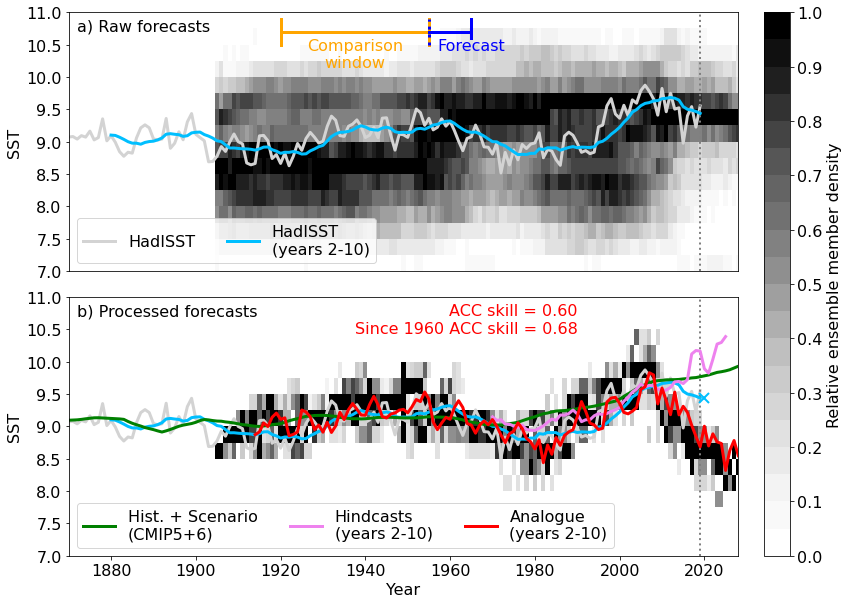

In [11]:
forecast_obs_lt210 = np.ma.masked_all(shape=nyrs)
for iyr, year in enumerate(year_forecast_obs):
    if (iyr+11) > nyrs:
        if (iyr+11) == (nyrs+1):
            forecast_obs_with_2020 = np.zeros(shape=(9))
            forecast_obs_with_2020[:8] = forecast_obs[iyr+2:iyr+10]
            forecast_obs_with_2020[8] = hadisst_spg_2020
            forecast_obs_lt210_2020 = np.ma.mean(forecast_obs_with_2020)
        continue
    forecast_obs_lt210[iyr] = np.ma.mean(forecast_obs[iyr+2:iyr+11])
year_forecast_obs_shifted = year_forecast_obs + 10
year_forecast_obs_shifted_masked = np.ma.masked_less(year_forecast_obs_shifted, 1960)
year_forecast_obs_shifted_masked = np.ma.masked_greater(year_forecast_obs_shifted_masked, 1990)

ann_forecast_lt210 = np.ma.mean(ann_forecast_recentred[:, 2:11], axis=1)
ind = np.nonzero(forecast_obs_lt210 * ann_forecast_lt210)
time_series_mean = np.ma.mean(ann_forecast_lt210[ind])
time_series_sd = np.ma.std(ann_forecast_lt210[ind])
ann_forecast_lt210_scaled = (ann_forecast_lt210 - time_series_mean) * (np.ma.std(forecast_obs_lt210[ind]) / time_series_sd) + np.ma.mean(forecast_obs_lt210[ind])

ind = np.nonzero(forecast_obs_lt210 * ann_forecast_lt210 * year_forecast_obs_shifted_masked)
ann_forecast_lt210_anomadjust = (ann_forecast_lt210 - np.ma.mean(ann_forecast_lt210[ind])) + np.ma.mean(forecast_obs_lt210[ind])

# levels_kde = np.linspace(0, 1.3e-1, num=21)
# levels_kde2 = np.linspace(0, 3e-1, num=21)
levels_kde = np.linspace(0, 1., num=21)
levels_kde2 = levels_kde

cmap_kde = plt.get_cmap('Greys')
norm_kde = BoundaryNorm(levels_kde, ncolors=cmap_kde.N, clip=True)
norm_kde2 = BoundaryNorm(levels_kde2, ncolors=cmap_kde.N, clip=True)

xlim = (1870, 2028)
# ylim = (yvalues[0], yvalues[-1])
ylim = [7, 11]
lw = 3
ilev1, ilev2 = 5, 12
textx, texty = 1872, 10.9
textx2 = 1990
mew = 2
markersize = 10

print(levels_kde[ilev1], levels_kde[ilev2])

ann_forecast_kde_contour_norm = ann_forecast_kde_contour / np.ma.sum(ann_forecast_kde_contour, axis=0)[np.newaxis, :]
ann_forecast_recentred_kde_contour_norm = ann_forecast_recentred_kde_contour / np.ma.sum(ann_forecast_recentred_kde_contour, axis=0)[np.newaxis, :]
cumul = np.cumsum(np.ma.array(ann_forecast_kde_contour_norm, fill_value=0.), axis=0)
cumul_recentred = np.cumsum(np.ma.array(ann_forecast_recentred_kde_contour_norm, fill_value=0.), axis=0)

# Overwrite with [0, 1] version
ann_forecast_kde_contour_norm = ann_forecast_kde_contour / np.ma.max(ann_forecast_kde_contour, axis=0)[np.newaxis, :]
ann_forecast_recentred_kde_contour_norm = ann_forecast_recentred_kde_contour / np.ma.max(ann_forecast_recentred_kde_contour, axis=0)[np.newaxis, :]

gs1 = gridspec.GridSpec(2, 1)
gs1.update(wspace=0.0, hspace=0.1)

plt.figure(figsize=(12, 10))
this_ax = plt.subplot(gs1[0, 0])
pos1 = this_ax.get_position()
clevs = plt.pcolormesh(year_reshaped_edges, edges, ann_forecast_kde_contour_norm, cmap=cmap_kde, norm=norm_kde, rasterized=True)
# plt.contour(year_reshaped, yvalues2, cumul, levels=[0.1, 0.9], colors='grey', linewidths=3)
# plt.contour(year_reshaped, yvalues2, cumul, levels=[0.5], colors='grey', linewidths=3)

plt.plot(np.array([1920, 1920+chosen_window]), np.array([10.7, 10.7]), color='orange', lw=3)
plt.plot(np.array([1920, 1920]), np.array([10.5, 10.9]), color='orange', lw=3)
plt.plot(np.array([1920, 1920])+chosen_window, np.array([10.5, 10.9]), color='orange', lw=3)
plt.text(1920+chosen_window/2., 10.6, "Comparison\nwindow", fontsize=fontsize, color='orange', horizontalalignment='center', verticalalignment='top')

plt.plot(np.array([1920+chosen_window, 1920+chosen_window+10]), np.array([10.7, 10.7]), color='blue', lw=3)
plt.plot(np.array([1920, 1920])+chosen_window, np.array([10.5, 10.9]), color='blue', lw=3, linestyle=':')
plt.plot(np.array([1920, 1920])+chosen_window+10, np.array([10.6, 10.9]), color='blue', lw=3)
plt.text(1920+chosen_window+10/2.+5., 10.6, "Forecast", fontsize=fontsize, color='blue', horizontalalignment='center', verticalalignment='top')

plt.plot(year_forecast_obs, forecast_obs, color='lightgrey', lw=lw, label='HadISST')
plt.ylabel(forecast_var, fontsize=fontsize)
plt.xlim(xlim)
# plt.ylim((7.5, 10.5))
plt.ylim(ylim)
plt.xticks([], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.axvline(year_forecast_obs[-1], linestyle=':', color='grey', lw=2)
plt.text(textx, texty, "a) Raw forecasts", fontsize=fontsize, verticalalignment='top')
# cb = plt.colorbar(clevs, orientation='vertical')
# cb.set_ticks([])
# cb.set_label("Raw forecasts from analogues (all lead times). Ensemble member density", fontsize=fontsize*1.2)

# LT2-10 in obs and analogue forecast (as that is what we are interested in). Careful with validity times.
plt.plot(year_forecast_obs_shifted, forecast_obs_lt210, color='deepskyblue', lw=lw, linestyle='-', label='HadISST\n(years 2-10)')

# HadISST Y2-10 incorporating the 9 months of 2020 as well, to see if it is trending down as we suggest
# plt.plot(2020, forecast_obs_lt210_2020, 'x', lw=lw, mew=mew, markersize=markersize)

ann_forecast_lt210 = np.ma.mean(ann_forecast_recentred[:, 2:11], axis=1)
ind = np.nonzero(forecast_obs_lt210 * ann_forecast_lt210)
ann_forecast_lt210_scaled = (ann_forecast_lt210 - np.ma.mean(ann_forecast_lt210[ind])) * (np.ma.std(forecast_obs_lt210[ind]) / np.ma.std(ann_forecast_lt210[ind])) + np.ma.mean(forecast_obs_lt210[ind])

ind = np.nonzero(forecast_obs_lt210 * ann_forecast_lt210 * year_forecast_obs_shifted_masked)
ann_forecast_lt210_anomadjust = (ann_forecast_lt210 - np.ma.mean(ann_forecast_lt210[ind])) + np.ma.mean(forecast_obs_lt210[ind])

# plt.plot(year_forecast_obs_shifted, ann_forecast_lt210_anomadjust, color='red', lw=lw, linestyle='--', label='Analogue forecast\n(years 2-10, anom. adjusted)')
# plt.plot(year_forecast_obs_shifted, ann_forecast_lt210_scaled, color='red', lw=lw, linestyle='--', label='Analogue forecast\n(years 2-10, normalised)')
# plt.legend(loc=0)

plt.legend(loc=3, ncol=2, fontsize=fontsize)
plt.ylabel(forecast_var, fontsize=fontsize)

this_ax = plt.subplot(gs1[1, 0])
pos2 = this_ax.get_position()
clevs = plt.pcolormesh(year_reshaped_edges, edges, ann_forecast_recentred_kde_contour_norm, cmap=cmap_kde, norm=norm_kde2, rasterized=True)
# clevs = plt.pcolormesh(year_reshaped, mids, ann_forecast_recentred_kde_contour_norm, cmap=cmap_kde, norm=norm_kde2, rasterized=True)

interval = mids[5] - mids[4]  # This is required to get the 10/50/90% _contours_ to align with the colormesh
# plt.contour(year_reshaped, mids+interval/2., cumul_recentred, levels=np.array([0.05, 0.95]), colors='white', linewidths=3)
# plt.contour(year_reshaped, mids+interval/2., cumul_recentred, levels=np.array([0.1, 0.9]), colors='white', linewidths=3)
# plt.contour(year_reshaped, mids+interval/2., cumul_recentred, levels=np.array([0.5]), colors='white', linewidths=3)

plt.plot(year_forecast_obs, forecast_obs, color='lightgrey', lw=lw)#, label='HadISST')
plt.ylabel(forecast_var, fontsize=fontsize)
plt.xlim(xlim)
# plt.ylim((7.5, 10.5))
plt.ylim(ylim)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.axvline(year_forecast_obs[-1], linestyle=':', color='grey', lw=2)
plt.text(textx, texty, "b) Processed forecasts", fontsize=fontsize, verticalalignment='top')
text = "ACC skill = {:.2f}\nSince 1960 ACC skill = {:.2f}"
plt.text(textx2, texty, text.format(ann_forecast_multiskill[-1], ann_forecast_multiskill1960[-1]),
         fontsize=fontsize, verticalalignment='top', horizontalalignment='right', color='red')
plt.xlabel('Year', fontsize=fontsize)

# cb.set_label("Processed forecasts from analogues (all lead times). Ensemble member density", fontsize=fontsize*1.2)

# LT2-10 in obs and analogue forecast (as that is what we are interested in). Careful with validity times.
plt.plot(year_forecast_obs_shifted, forecast_obs_lt210, color='deepskyblue', lw=lw, linestyle='-')#, label='HadISST\n(years 2-10)')


# DELETE THIS
############
# savefile = '/home/mmenary/temp.pkl'
# with open(savefile, 'rb') as handle:
#     historical_time_series_anom_ensmn = pickle.load(handle)
# historical_time_series_anom_ensmn_mmm = np.ma.mean(historical_time_series_anom_ensmn, axis=0)
# max_lead_multi = 11
# forecast = np.ma.masked_all(shape=(nyrs, max_lead_multi))
# for ilead in range(max_lead_multi):
#     forecast[:nyrs-ilead, ilead] = historical_time_series_anom_ensmn_mmm[ilead:]
# plt.plot((year_forecast_obs_shifted)[:-11], np.ma.mean(forecast[:, 2:11], axis=1)[:-11]+forecast_obs_lt210.mean(),
#          lw=lw, label='HIST', color='green')

savefile = '/home/users/lfbor/data/temp2.pkl'
nyrs2 = 251
year_forecast_obs_shifted2 = np.arange(nyrs2) + 1850 + 10
with open(savefile, 'rb') as handle:
    historical_time_series_anom_ensmn = pickle.load(handle, encoding='latin')
historical_time_series_anom_ensmn_mmm = np.ma.mean(historical_time_series_anom_ensmn, axis=0)
max_lead_multi = 11
forecast = np.ma.masked_all(shape=(nyrs2, max_lead_multi))
for ilead in range(max_lead_multi):
    forecast[:nyrs2-ilead, ilead] = historical_time_series_anom_ensmn_mmm[ilead:]
plt.plot((year_forecast_obs_shifted2)[:-11], np.ma.mean(forecast[:, 2:11], axis=1)[:-11]+forecast_obs_lt210.mean(),
         lw=lw, label='Hist. + Scenario\n(CMIP5+6)', color='green')

# hind_ts = hindcast_time_series_ensmn_ltbc_mmm - hindcast_time_series_ensmn_ltbc_mmm[t0:t1, :].mean()
# hind_ts = np.ma.mean(hind_ts[:, 2:11], axis=1)
# hind_ts += forecast_obs_lt210.mean()
# plt.plot(year_forecast_obs_shifted, hind_ts, color='violet', linestyle='-', label='Hindcasts\n(years 2-10)', lw=2)

hind_ts = hindcast_time_series_ensmn_ltbc_mm40m_lt2t10 - hindcast_time_series_ensmn_ltbc_mm40m_lt2t10[t0:t1].mean()
hind_ts += forecast_obs_lt210.mean()
plt.plot(year_forecast_obs_shifted, hind_ts, color='violet', linestyle='-', label='Hindcasts\n(years 2-10)', lw=3)
############


# HadISST Y2-10 incorporating the 9 months of 2020 as well, to see if it is trending down as we suggest
plt.plot(2020, forecast_obs_lt210_2020, 'x', color='deepskyblue', lw=lw, mew=mew, markersize=markersize, markerfacecolor='None')
# plt.plot(2020, hadisst_spg_2020, 'x', color='lightgrey', lw=lw, mew=mew, markersize=markersize, markerfacecolor='None')

# plt.plot(year_forecast_obs_shifted, ann_forecast_lt210_anomadjust, color='red', lw=lw, linestyle='--', label='Analogue forecast\n(years 2-10, anom. adjusted)')
plt.plot(year_forecast_obs_shifted, ann_forecast_lt210_scaled, color='red', lw=lw, linestyle='-', label='Analogue\n(years 2-10)')
plt.legend(loc=0)

# Note that if we plot the year-10 we can see whether the "analogue" is any different from the underlying obs.
# Where it isn't, we know that there is nothing but noise (i.e. the averaging over ensemble members = 0). Where it
# is different we know that there is at least some signal (although it isn't necessarilly skilful). This basically
# shows that before 1970 we have nothing but noise.
# plt.plot(year_forecast_obs_shifted-10, ann_forecast_lt210_scaled, color='red', lw=lw, linestyle='-', label='Analogue\n(years 2-10)')

plt.legend(loc=3, ncol=3, fontsize=fontsize)
plt.ylabel(forecast_var, fontsize=fontsize)

print(pos2)

cax = plt.gcf().add_axes([0.93, pos2.y0, 0.03, pos1.y1-pos2.y0])
cb = plt.colorbar(clevs, cax=cax, orientation='vertical')
cb.set_ticks(levels_kde2[::2])
cb.ax.tick_params(labelsize=fontsize)
cb.set_label("Relative ensemble member density", fontsize=fontsize)

print(fig_save_file4)
plt.savefig(fig_save_file4, bbox_inches = 'tight')

In [12]:
# Would be good to normalise this against the total number of simulated years for each experiment

#corr_info = trend_corr_info[:, max_mems_to_take-chosen_num_mem:, :].copy()
corr_info = trend_corr_info[:, max_mems_to_take-chosen_num_mem:].copy()
model_matrix, expt_matrix, models, expts, expts_used = make_info_matrices(corr_info, year_forecast_obs, chosen_num_mem)

main_expts = expts[:10]
nmain_expts = len(main_expts)
print(main_expts)

experiment_count = np.ma.zeros(shape=(nmain_expts+1, nyrs))
for jj in range(chosen_num_mem):
    for iyr, year in enumerate(year_forecast_obs):
        expt_num = expt_matrix[iyr, jj]
        if np.ma.is_masked(expt_num):
            continue
        if expt_num >= nmain_expts:
            raise ValueError(expt_num)
        experiment_count[expt_num+1, iyr] += 1

experiment_count_cumsum = np.cumsum(experiment_count, axis=0)
ind = np.argwhere(experiment_count_cumsum[-1, :] < chosen_num_mem)
if len(ind) > 0:
    experiment_count_cumsum[:, :ind[-1][0]+1] = np.ma.masked

forecast_obs_scaled = (forecast_obs - forecast_obs.mean()) * ((chosen_num_mem / 10.) / forecast_obs.std()) + chosen_num_mem / 2.

expt_colors2 = ['grey', 'orange', 'green', 'cyan', 'cyan', 'cyan', 'red', 'red', 'red', 'red']
# expt_colors2 = ['grey', 'orange', 'cyan', 'cyan', 'cyan', 'cyan', 'red', 'red', 'violet', 'violet']

alpha = 1

plt.figure(figsize=(15, 10))
for iexpt, expt in enumerate(main_expts):
    lower = experiment_count_cumsum[iexpt]
    upper = experiment_count_cumsum[iexpt+1]
    plt.fill_between(year_forecast_obs, lower, upper, alpha=alpha, color=expt_colors2[iexpt], label=expt)
plt.xlim(xlim)
plt.ylim(0, chosen_num_mem)
plt.xlabel('Year', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(np.arange(chosen_num_mem+1), fontsize=fontsize)
plt.legend(loc=3)

plt.plot(year_forecast_obs, forecast_obs_scaled, color='k', label='Obs (TRUTH)')
plt.axhline(10, linestyle=':', color='k')

print(fig_save_file3)
plt.savefig(fig_save_file3, bbox_inches = 'tight')

corr_info = ann_corr_info[:, max_mems_to_take-chosen_num_mem:, :].copy()
model_matrix, expt_matrix, models, expts, expts_used = make_info_matrices(corr_info, year_forecast_obs, chosen_num_mem)

experiment_count = np.ma.zeros(shape=(nmain_expts+1, nyrs))
for jj in range(chosen_num_mem):
    for iyr, year in enumerate(year_forecast_obs):
        expt_num = expt_matrix[iyr, jj]
        if np.ma.is_masked(expt_num):
            continue
        if expt_num >= nmain_expts:
            raise ValueError(expt_num)
        experiment_count[expt_num+1, iyr] += 1

experiment_count_cumsum = np.cumsum(experiment_count, axis=0)
ind = np.argwhere(experiment_count_cumsum[-1, :] < chosen_num_mem)
if len(ind) > 0:
    experiment_count_cumsum[:, :ind[-1][0]+1] = np.ma.masked

forecast_obs_scaled = (forecast_obs - forecast_obs.mean()) * ((chosen_num_mem / 10.) / forecast_obs.std()) + chosen_num_mem / 2.

plt.figure(figsize=(15, 10))
for iexpt, expt in enumerate(main_expts):
    lower = experiment_count_cumsum[iexpt]
    upper = experiment_count_cumsum[iexpt+1]
    plt.fill_between(year_forecast_obs, lower, upper, alpha=alpha, color=expt_colors2[iexpt], label=expt)
plt.xlim(xlim)
plt.ylim(0, chosen_num_mem)
plt.xlabel('Year', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(np.arange(chosen_num_mem+1), fontsize=fontsize)
plt.legend(loc=3)

plt.plot(year_forecast_obs, forecast_obs_scaled, color='k', label='Obs (TRUTH)')
plt.axhline(10, linestyle=':', color='k')

print(fig_save_file3b)
plt.savefig(fig_save_file3b, bbox_inches = 'tight')

ValueError: 67.6588467264414 is not in list

In [14]:
# ===============
# As above but nicer looking - just for the ANN version
# ===============

year_model_historical = 1850 + np.arange(251)
method = 'ann'

corr_info = ann_corr_info[:, max_mems_to_take-chosen_num_mem:, :].copy()
model_matrix, expt_matrix, models, expts, expts_used = make_info_matrices(corr_info, year_forecast_obs, chosen_num_mem)
#                         print models
models_padded = models[:]
for jj, model in enumerate(models):
#                             print jj, model
    if (jj % 2) == 0:
        models_padded[jj] = model + ' ' * 25

# within this range for historical then make different colour
tolerance1 = 20  
tolerance2 = 10
tolerance3 = 3
hist_colors = ['pink', 'purple', 'red']
# hist_colors = ['orange', 'orange', 'orange']

expts_sorted = expts[:]
expt_colors_sorted = expt_colors[:]

for color, tolerance in zip(hist_colors, [tolerance3, tolerance2, tolerance1]):
    text = 'historical\n(within {:d} years)'.format(tolerance)
    expts_sorted.insert(2, text)
    expt_colors_sorted.insert(2, color)
    expts_used.insert(2, text)

plt.figure(figsize=(15, 15))
for jj in range(chosen_num_mem):
#     if jj > 5: continue
    for iyr, year in enumerate(year_forecast_obs):
        model_num = model_matrix[iyr, jj]
        if (model_num % 3) == 0:
            marker = 'x'
        elif (model_num % 3) == 1:
            marker = 'o'
        elif (model_num % 3) == 2:
            marker = '^'
        else:
            continue  # If masked
            
        color = expt_colors[expt_matrix[iyr, jj]]
        if (expts_used[expt_matrix[iyr, jj]] == 'historical'):
            this_index = corr_info[iyr, jj, 4]
            year_diff = np.abs(year_model_historical[this_index] - year)
            if year_diff < tolerance3:
                color = hist_colors[0]
            elif year_diff < tolerance2:
                color = hist_colors[1]
            elif year_diff < tolerance1:
                color = hist_colors[2]
            
        plt.plot(year_forecast_obs[iyr], model_num, marker, color=color, markerfacecolor='None', mew=2, markersize=7)
        
plt.xlabel('Year', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(np.arange(len(models)))
plt.gca().set_yticklabels(models_padded, fontsize=10)
plt.title('{:s} method: The model(s) and experiment(s) used in each window'.format(method), fontsize=fontsize)
plt.xlim(xlim)
plt.ylim(-1, len(models))
for num in range(0, len(models), 3):
    plt.axhline(num, linestyle=':', color='grey')

custom_lines = []
for jj, this_expt in enumerate(expts_sorted):
    if this_expt not in expts_used:
        continue
    custom_lines.append(Line2D([0], [0], color=expt_colors_sorted[jj], lw=2))
plt.legend(custom_lines, expts_used, loc=3, fontsize=fontsize, handlelength=1.2)

print(fig_save_file1d)
plt.savefig(fig_save_file1d, bbox_inches = 'tight')

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [16]:
# Not sure how useful/relevant this is - this is the END of the window/start of the forecast (i.e. lead=0)

# This could do with tidying up if we want to keep it
corr_info = ann_corr_info[:, max_mems_to_take-chosen_num_mem:, :].copy()
print(corr_info.shape)
print(corr_info[100, 0, :])

corr_info_hist_years = np.ma.masked_all(shape=(chosen_num_mem, nyrs))  # The hist-year that was chosen
corr_info_hist_years_diff = np.ma.masked_all(shape=(chosen_num_mem, nyrs))  # The diff to the REAL hist-year
for iyr, year in enumerate(year_forecast_obs):
    for imem in range(chosen_num_mem):
        this_expt = corr_info[iyr, imem, 2]
        if this_expt != "historical":
            continue
        this_index = corr_info[iyr, imem, 4]
        if not np.ma.is_masked(this_index):
#             print this_index
            corr_info_hist_years[imem, iyr] = year_model_historical[this_index]
            corr_info_hist_years_diff[imem, iyr] = year_model_historical[this_index] - year

corr_info_hist_years_diff_mn = np.ma.mean(corr_info_hist_years_diff, axis=0)
mn = np.ma.mean(corr_info_hist_years_diff_mn)
sd = np.ma.std(corr_info_hist_years_diff_mn)
sd_scaling = chosen_num_mem / 7.
centreline = chosen_num_mem / 2.
corr_info_hist_years_diff_mn_scaled = (corr_info_hist_years_diff_mn - mn) * (sd_scaling / sd) + centreline

# Bootstrap some shuffled data to see what the expected downwards trend is
nboot = 200
corr_info_hist_years_diff_mn_scaled_random = np.ma.masked_all(shape=(nboot, nyrs))
for iboot in range(nboot):
    corr_info_hist_years_random = np.zeros(shape=corr_info_hist_years.shape)
    for imem in range(chosen_num_mem):
        corr_info_hist_years_random[imem, chosen_window:] = np.random.permutation(corr_info_hist_years[imem, chosen_window:])
    corr_info_hist_years_random = np.ma.masked_less(corr_info_hist_years_random, 1.)
    corr_info_hist_years_random = np.ma.masked_greater(corr_info_hist_years_random, 2050)
    corr_info_hist_years_diff_random = np.ma.masked_all(shape=corr_info_hist_years.shape)
    for iyr, year in enumerate(year_forecast_obs):
        corr_info_hist_years_diff_random[:, iyr] = corr_info_hist_years_random[:, iyr] - year

    corr_info_hist_years_diff_mn_random = np.ma.mean(corr_info_hist_years_diff_random, axis=0)
    mn = np.ma.mean(corr_info_hist_years_diff_mn_random)
    sd = np.ma.std(corr_info_hist_years_diff_mn_random)
    sd_scaling = chosen_num_mem / 7.
    centreline = chosen_num_mem / 2.
    corr_info_hist_years_diff_mn_scaled_random[iboot, :] = (corr_info_hist_years_diff_mn_random - mn) * (sd_scaling / sd) + centreline
corr_info_hist_years_diff_mn_scaled_random_mn = np.ma.mean(corr_info_hist_years_diff_mn_scaled_random, axis=0)

plt.figure(figsize=(15, 20))
plt.subplot(3, 1, 1)
plt.pcolormesh(year_forecast_obs, np.arange(chosen_num_mem), corr_info_hist_years)
plt.colorbar()

cmap = plt.get_cmap('coolwarm')
plt.subplot(3, 1, 2)
plt.pcolormesh(year_forecast_obs, np.arange(chosen_num_mem), corr_info_hist_years_diff, cmap=cmap, vmin=-50, vmax=50)
plt.plot(year_forecast_obs, corr_info_hist_years_diff_mn_scaled, color='k', lw=3)
plt.plot(year_forecast_obs, corr_info_hist_years_diff_mn_scaled_random_mn, color='k', lw=4, linestyle=':')
plt.axhline(centreline, color='k', linestyle='--', lw=2)
plt.colorbar()
title = 'Analogue hist year - real hist year. Red means analogue is LATER on than reality\n' + \
        'Dotted: Would expect a gradual trend from red to blue in the case of just noise'
plt.title(title)

cmap = plt.get_cmap('viridis')
plt.subplot(3, 1, 3)
plt.pcolormesh(year_forecast_obs, np.arange(chosen_num_mem), np.abs(corr_info_hist_years_diff), cmap=cmap, vmin=0, vmax=50)
plt.colorbar()
plt.title('As above but for absolute values')


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
# Would be good to normalise this against the total number of simulated years for each experiment

main_expts = expts[:10]
nmain_expts = len(main_expts)
print main_expts

corr_info = trend_corr_info[:, max_mems_to_take-chosen_num_mem:, :]
model_matrix, expt_matrix, models, expts, expts_used = make_info_matrices(corr_info, year_forecast_obs, chosen_num_mem)

experiment_count = np.ma.zeros(shape=(nmain_expts+1, nyrs))
for jj in range(chosen_num_mem):
    for iyr, year in enumerate(year_forecast_obs):
        expt_num = expt_matrix[iyr, jj]
        if np.ma.is_masked(expt_num):
            continue
        if expt_num >= nmain_expts:
            raise ValueError(expt_num)
        experiment_count[expt_num+1, iyr] += 1

experiment_count_cumsum = np.cumsum(experiment_count, axis=0)
ind = np.argwhere(experiment_count_cumsum[-1, :] < chosen_num_mem)[-1][0]

print len(np.argwhere(experiment_count_cumsum[-1, :] < chosen_num_mem))
print ind

In [ ]:
print corr_info_hist_years_diff_random[:, 148]
print np.ma.mean(corr_info_hist_years_diff_random[:, 148])
print corr_info_hist_years_random[:, 148]
print corr_info_hist_years_diff_mn_random[148]

print corr_info_hist_years.shape

In [ ]:
# import analogue
# reload(analogue)
# from analogue import *

In [ ]:
# =================
# Plot the lead time dependent skill wrt baseline measures
# Bottom right plot is the relevant one...
# =================
fontsize = 16
#                     ylim = (-0.3, 1.1)
ylim = (-0.1, 1.1)
lw = 3

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plot_baseline_data(baseline_save_file, multi=False)
for num in [-1, 0, 1]:
    plt.axhline(num, linestyle=':', color='k')
plt.plot(lead_times, trend_forecast_skill, color='red', label='Analogue (trend-based)', lw=lw)
plt.plot(lead_times, trend_forecast_skill1960, color='red', linestyle='--', label='Analogue (trend-based) (since 1960)', lw=lw)
plt.plot(lead_times, trend_forecast_res_skill, color='red', linestyle=':', label='Analogue (trend-based) RESIDUAL', lw=lw)
plt.plot(lead_times, trend_forecast_skill1990, color='red', linestyle='-.', label='Analogue (trend-based) (BEFORE 1990)', lw=lw)
plt.plot(lead_times, random_forecast_skill, color='orange', linestyle='-', label='Random noise', lw=lw)
plt.ylabel('Correlation', fontsize=fontsize)
plt.xlabel('Lead time [years]', fontsize=fontsize)
plt.xticks(np.arange(nlead), fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('TREND: Target: {:s}\nLead time dependent skill'.format(chosen_target_region), fontsize=fontsize)
plt.ylim(ylim)
plt.xlim(0, 10)
plt.legend(loc=2, ncol=3, fontsize=fontsize*0.8, bbox_to_anchor=(0, -0.1))

index_sets = [[0, 1, 2, 3, 4, 5], [6, 7]]
plt.subplot(1, 2, 2)
plot_baseline_data(baseline_save_file, multi=True, lead_times_multi=lead_times_multi)
for ii, ind in enumerate(index_sets):
    for num in [-1, 0, 1]:
        plt.axhline(num, linestyle=':', color='k')
    plt.plot(lead_times_multi[ind], trend_forecast_multiskill[ind], color='red', lw=lw)
    plt.plot(lead_times_multi[ind], trend_forecast_multiskill1960[ind], color='red', linestyle='--', lw=lw)
    plt.plot(lead_times_multi[ind], trend_forecast_multiskill1990[ind], color='red', linestyle='-.', lw=lw)
    plt.plot(lead_times_multi[ind], trend_forecast_res_multiskill[ind], color='red', linestyle=':', lw=lw)
    plt.plot(lead_times_multi[ind], random_forecast_multiskill[ind], color='orange', linestyle='-', lw=lw)
plt.xlabel('Lead time [MULTIPLE years]', fontsize=fontsize)
plt.xticks(np.arange(len(start_lead)), fontsize=fontsize)
plt.gca().set_xticklabels(labels=labels_multi)
plt.yticks([], fontsize=fontsize)
plt.title('TREND: Target: {:s}\nMulti-annual lead time dependent skill'.format(chosen_target_region), fontsize=fontsize)
plt.ylim(ylim)

print fig_save_file2
plt.savefig(fig_save_file2, bbox_inches = 'tight')
# plt.close(plt.gcf())

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plot_baseline_data(baseline_save_file, multi=False)
for num in [-1, 0, 1]:
    plt.axhline(num, linestyle=':', color='k')
plt.plot(lead_times, ann_forecast_skill, color='red', label='Analogue (ann-based)', lw=lw)
plt.plot(lead_times, ann_forecast_skill1960, color='red', linestyle='--', label='Analogue (ann-based) (since 1960)', lw=lw)
plt.plot(lead_times, ann_forecast_res_skill, color='red', linestyle=':', label='Analogue (ann-based) RESIDUAL', lw=lw)
plt.plot(lead_times, ann_forecast_skill1990, color='red', linestyle='-.', label='Analogue (ann-based) (BEFORE 1990)', lw=lw)
plt.plot(lead_times, random_forecast_skill, color='orange', linestyle='-', label='Random noise', lw=lw)
plt.plot(lead_times, random_forecast_skill1960, color='orange', linestyle='--', label='Random noise (since 1960)', lw=lw)
plt.plot(lead_times, random_forecast_skill1990, color='orange', linestyle='-.', label='Random noise (before 1990)', lw=lw)
plt.ylabel('Correlation', fontsize=fontsize)
plt.xlabel('Lead time [years]', fontsize=fontsize)
plt.xticks(np.arange(nlead), fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('ANN: Target: {:s}\nLead time dependent skill'.format(chosen_target_region), fontsize=fontsize)
plt.ylim(ylim)
plt.xlim(0, 10)
plt.legend(loc=2, ncol=3, fontsize=fontsize*0.8, bbox_to_anchor=(0, -0.1))

plt.subplot(1, 2, 2)
plot_baseline_data(baseline_save_file, multi=True, lead_times_multi=lead_times_multi)
for ii, ind in enumerate(index_sets):
    for num in [-1, 0, 1]:
        plt.axhline(num, linestyle=':', color='k')
    plt.plot(lead_times_multi[ind], ann_forecast_multiskill[ind], color='red', lw=lw)
    plt.plot(lead_times_multi[ind], ann_forecast_multiskill1960[ind], color='red', linestyle='--', lw=lw)
    plt.plot(lead_times_multi[ind], ann_forecast_multiskill1990[ind], color='red', linestyle='-.', lw=lw)
    plt.plot(lead_times_multi[ind], ann_forecast_res_multiskill[ind], color='red', linestyle=':', lw=lw)
    plt.plot(lead_times_multi[ind], random_forecast_multiskill[ind], color='orange', linestyle='-', lw=lw)
    plt.plot(lead_times_multi[ind], random_forecast_multiskill1960[ind], color='orange', linestyle='--', lw=lw)
    plt.plot(lead_times_multi[ind], random_forecast_multiskill1990[ind], color='orange', linestyle='-.', lw=lw)
plt.xlabel('Lead time [MULTIPLE years]', fontsize=fontsize)
plt.xticks(np.arange(len(start_lead)), fontsize=fontsize)
plt.gca().set_xticklabels(labels=labels_multi)
plt.yticks([], fontsize=fontsize)
plt.title('ANN: Target: {:s}\nMulti-annual lead time dependent skill'.format(chosen_target_region), fontsize=fontsize)
plt.ylim(ylim)

print fig_save_file2b
plt.savefig(fig_save_file2b, bbox_inches = 'tight')
# plt.close(plt.gcf())


In [ ]:
print ann_forecast_multiskill1960

In [ ]:
with open(baseline_save_file, 'rb') as handle:
    print('Reading from {:s}'.format(baseline_save_file))
    baseline_data = pickle.load(handle)
    hist_models = baseline_data['hist_models']
    hind_models = baseline_data['hind_models']
    historical_mmm = baseline_data['historical_mmm']
    historical_anom_ensmn_corr = baseline_data['historical_anom_ensmn_corr']
    historical_anom_ensmn_mmm_corr = baseline_data['historical_anom_ensmn_mmm_corr']
    historical_anom_ensmn_mmm1960_corr = baseline_data['historical_anom_ensmn_mmm1960_corr']
    historical_anom_ensmn_mmm1990_corr = baseline_data['historical_anom_ensmn_mmm1990_corr']
    historical_anom_ensmn_mmmsub_multicorr = baseline_data['historical_anom_ensmn_mmmsub_multicorr']
    historical_anom_ensmn_mmmsub1960_multicorr = baseline_data['historical_anom_ensmn_mmmsub1960_multicorr']
    hindcast_time_series_ensmn_mmm_corr = baseline_data['hindcast_time_series_ensmn_mmm_corr']
    hindcast_time_series_ensmn_ltbc_mmm_corr = baseline_data['hindcast_time_series_ensmn_ltbc_mmm_corr']
    historical_anom_inf_ensmn_mmm_corr = baseline_data['historical_anom_inf_ensmn_mmm_corr']
    persistence_corr = baseline_data['persistence_corr']
    persistence_res_corr = baseline_data['persistence_res_corr']
    persistence_smoothed_corr = baseline_data['persistence_smoothed_corr']
    persistence1960_corr = baseline_data['persistence1960_corr']
    persistence1990_corr = baseline_data['persistence1990_corr']
    historical_anom_ensmn_multicorr = baseline_data['historical_anom_ensmn_multicorr']
    historical_anom_ensmn_mmm_multicorr = baseline_data['historical_anom_ensmn_mmm_multicorr']
    historical_anom_ensmn_mmm1960_multicorr = baseline_data['historical_anom_ensmn_mmm1960_multicorr']
    # historical_anom_ensmn_mmm1990_multicorr = baseline_data['historical_anom_ensmn_mmm1990_multicorr']
    hindcast_time_series_ensmn_mmm_multicorr = baseline_data['hindcast_time_series_ensmn_mmm_multicorr']
    hindcast_time_series_ensmn_ltbc_mmm_multicorr = baseline_data['hindcast_time_series_ensmn_ltbc_mmm_multicorr']
    hindcast_time_series_ensmn_ltbc_mmm5_multicorr = baseline_data['hindcast_time_series_ensmn_ltbc_mmm5_multicorr']
    hindcast_time_series_ensmn_ltbc_mmm6_multicorr = baseline_data['hindcast_time_series_ensmn_ltbc_mmm6_multicorr']
    historical_anom_inf_ensmn_mmm_multicorr = baseline_data['historical_anom_inf_ensmn_mmm_multicorr']
    persistence_multicorr = baseline_data['persistence_multicorr']
    persistence_res_multicorr = baseline_data['persistence_res_multicorr']
    persistence_smoothed_multicorr = baseline_data['persistence_smoothed_multicorr']
    persistence1960_multicorr = baseline_data['persistence1960_multicorr']
    hindcast_time_series_ensmn_mmm_res_ltbc_corr = baseline_data['hindcast_time_series_ensmn_mmm_res_ltbc_corr']
    hindcast_time_series_ensmn_mmm_res_ltbc_multicorr = baseline_data['hindcast_time_series_ensmn_mmm_res_ltbc_multicorr']
    mpi_ensmn_corr = baseline_data['mpi_ensmn_corr']
    mpi_ensmn1960_corr = baseline_data['mpi_ensmn1960_corr']
    mpi_ensmn1990_corr = baseline_data['mpi_ensmn1990_corr']
    mpi_ensmn_multicorr = baseline_data['mpi_ensmn_multicorr']
    mpi_ensmn1960_multicorr = baseline_data['mpi_ensmn1960_multicorr']
    mpi_ensmn1990_multicorr = baseline_data['mpi_ensmn1990_multicorr']
        
# import analogue
# reload(analogue)
# from analogue import *

fontsize = 16
lw1 = 3
lw2 = 2

plt.figure(figsize=(6, 7))
for ii, ind in enumerate(index_sets):
    if ii == 0:
        label_anal = 'Analogue'
        label_anal1960 = 'Analogue (since 1960)'
        label_rand = 'Shuffled'
        label_rand1960 = 'Shuffled (since 1960)'
        historical_anom_ensmn_mmm_multicorr_label = 'CMIP5+6 hist. (MMM)'
        historicalsub_anom_ensmn_mmm_multicorr_label = 'CMIP5+6 hist. Sub (MMM)'
        hindcast_time_series_ensmn_ltbc_mmm_multicorr_label = 'CMIP5+6 init.\n(since 1960, MMM)'
        hindcast_time_series_ensmn_ltbc_mmm5_multicorr_label = 'CMIP5 init.\n(since 1960, MMM)'
        hindcast_time_series_ensmn_ltbc_mmm6_multicorr_label = 'CMIP6 init.\n(since 1960, MMM)'
        historical_anom_ensmn_mmm1960_multicorr_label = 'CMIP5+6 hist.\n(since 1960, MMM)'
        persistence_multicorr_label = 'Persistence (obs)'
        persistence1960_multicorr_label = 'Persistence\n(since 1960, obs)'
        mpi_ensmn_multicorr_label = 'MPI long init.\n(3 mems)'
        mpi_ensmn1960_multicorr_label = 'MPI long init.\n(since 1960, mems)'
    else:
        label_anal = ''
        label_anal1960 = ''
        label_rand = ''
        label_rand1960 = ''
        historical_anom_ensmn_mmm_multicorr_label = ''
        historicalsub_anom_ensmn_mmm_multicorr_label = ''
        hindcast_time_series_ensmn_ltbc_mmm_multicorr_label = ''
        hindcast_time_series_ensmn_ltbc_mmm5_multicorr_label = ''
        hindcast_time_series_ensmn_ltbc_mmm6_multicorr_label = ''
        historical_anom_ensmn_mmm1960_multicorr_label = ''
        persistence_multicorr_label = ''
        persistence1960_multicorr_label = ''
        mpi_ensmn_multicorr_label = ''
        mpi_ensmn1960_multicorr_label = ''
    plt.plot(lead_times_multi[ind], ann_forecast_multiskill[ind], color='red', lw=lw1, label=label_anal)
    plt.plot(lead_times_multi[ind], random_forecast_multiskill[ind], color='orange', linestyle='-', lw=lw2, label=label_rand)
    plt.plot(lead_times_multi[ind], historical_anom_ensmn_mmm_multicorr[ind], color='green', lw=lw2, label=historical_anom_ensmn_mmm_multicorr_label)
    plt.plot(lead_times_multi[ind], historical_anom_ensmn_mmmsub_multicorr[ind], color='green', lw=lw2*1.5, label=historicalsub_anom_ensmn_mmm_multicorr_label)
    plt.plot(lead_times_multi[ind], persistence_multicorr[ind], color='dimgrey', lw=lw2, label=persistence_multicorr_label)
    plt.plot(lead_times_multi[ind], mpi_ensmn_multicorr[ind], color='blue', lw=lw2, label=mpi_ensmn_multicorr_label)
    plt.plot([0], color='white', label=' ')

    plt.plot(lead_times_multi[ind], ann_forecast_multiskill1960[ind], color='red', linestyle='--', lw=lw1, label=label_anal1960)
    plt.plot(lead_times_multi[ind], random_forecast_multiskill1960[ind], color='orange', linestyle='--', lw=lw2, label=label_rand1960)
    plt.plot(lead_times_multi[ind], historical_anom_ensmn_mmm1960_multicorr[ind], color='green', linestyle='--', lw=lw2, label=historical_anom_ensmn_mmm1960_multicorr_label)
    plt.plot(lead_times_multi[ind], historical_anom_ensmn_mmmsub1960_multicorr[ind], color='green', linestyle='--', lw=lw2*1.5, label=historicalsub_anom_ensmn_mmm_multicorr_label)
    plt.plot(lead_times_multi[ind], persistence1960_multicorr[ind], color='dimgrey', linestyle='--', lw=lw2, label=persistence1960_multicorr_label)
    plt.plot(lead_times_multi[ind], mpi_ensmn1960_multicorr[ind], color='blue', linestyle='--', lw=lw2, label=mpi_ensmn1960_multicorr_label)

    plt.plot(lead_times_multi[ind], hindcast_time_series_ensmn_ltbc_mmm_multicorr[ind], linestyle='--', lw=lw1, color='indigo', label=hindcast_time_series_ensmn_ltbc_mmm_multicorr_label)
    plt.plot(lead_times_multi[ind], hindcast_time_series_ensmn_ltbc_mmm5_multicorr[ind], linestyle=':', lw=lw1, color='indigo', label=hindcast_time_series_ensmn_ltbc_mmm5_multicorr_label)
    plt.plot(lead_times_multi[ind], hindcast_time_series_ensmn_ltbc_mmm6_multicorr[ind], linestyle='-.', lw=lw1, color='indigo', label=hindcast_time_series_ensmn_ltbc_mmm6_multicorr_label)


plt.xlabel('Lead time [multiple years]', fontsize=fontsize)
plt.xticks(np.arange(len(start_lead)), fontsize=fontsize)
plt.gca().set_xticklabels(labels=labels_multi)
# plt.yticks([], fontsize=fontsize)
plt.ylabel('Multi-annual lead time dependent skill', fontsize=fontsize)
plt.ylim([0.35, 0.95])
plt.yticks(fontsize=fontsize)

plt.legend(loc=2, ncol=1, fontsize=fontsize, bbox_to_anchor=(1, 1.03))

print fig_save_file2b
plt.savefig(fig_save_file2b, bbox_inches = 'tight')